In [28]:
import pandas as pd
from database.adatabase import ADatabase
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from tqdm import tqdm
from processor.processor import Processor as processor
from asset.exposure import Exposure

In [12]:
sec = ADatabase("sec")
market = ADatabase("market")

In [15]:
market.connect()
index = market.retrieve("sp500")[::10]
market.disconnect()
factors = ["assets","liabilities","adjclose"]


In [16]:
market.connect()
sec.connect()
factors_df = []
for row in tqdm(index.iterrows()):
    try:
        ticker = row[1]["ticker"]
        cik = int(row[1]["CIK"])
        price = processor.column_date_processing(market.query("prices",{"ticker":ticker}))
        price["year"] = [x.year for x in price["date"]]
        price["quarter"] = [x.quarter for x in price["date"]]
        filings = processor.column_date_processing(sec.query("filings",{"cik":cik}))
        filings["year"] = [x.year if x.quarter < 4 else x.year + 1 for x in filings["date"]]
        filings["quarter"] = [x.quarter + 1 if x.quarter < 4 else 1 for x in filings["date"]]
        price = price.drop(["date","ticker"],axis=1).merge(filings.drop(["date","cik"],axis=1),on=["year","quarter"],how="left").groupby(["year","quarter"]).mean().reset_index()
        price["ticker"] = ticker
        price["y"] = price["adjclose"].shift(-1)
        factors_df.append(price[["year","quarter","ticker","y"]+factors])
    except Exception as e:
        print(ticker,str(e))
        continue
sec.disconnect()
market.disconnect()
factors_df = pd.concat(factors_df).sort_values(["year","quarter"])

11it [00:00, 21.00it/s]

BRK.B 'date'


51it [00:02, 20.23it/s]


In [17]:
model = XGBRegressor()
training_data = factors_df[(factors_df["year"]>=2013) & (factors_df["year"]<2020)]
sim = factors_df[(factors_df["year"]>=2019) ]
model.fit(training_data[factors],training_data["y"])
sim["prediction"] = model.predict(sim[factors])

C:\Users\eric\AppData\Local\Temp\ipykernel_2028\1586336090.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim["prediction"] = model.predict(sim[factors])


,year,quarter,ticker,y,assets,liabilities,adjclose,prediction
56,2024,4,UNP,NaN,6.747450e+10,5.183600e+10,236.437574,232.163177
56,2024,4,VRSK,NaN,4.567000e+09,4.188250e+09,278.073514,294.370056
56,2024,4,WAB,NaN,1.893200e+10,8.410000e+09,193.621154,198.842896
56,2024,4,WST,NaN,3.659450e+09,9.305500e+08,312.933174,309.121948
56,2024,4,ZBH,NaN,2.139495e+10,8.956750e+09,107.373966,108.570679


In [19]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]):
    try:
        price = p.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date",inplace=True)
        price["year"] = [x.year for x in price["date"]]
        price["quarter"] = [x.quarter for x in price["date"]]
        price.sort_values("date",inplace=True)
        price = price.merge(sim[["year","quarter","ticker","prediction"]],on=["year","quarter","ticker"],how="left")
        prices.append(price)
    except:
        continue
market.disconnect()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:02<00:00, 20.81it/s]


In [88]:
simulation = pd.concat(prices).dropna()

In [89]:
simulation["factor"] = simulation["prediction"]/simulation["adjclose"] - 1

In [90]:
simulation["rank"] = simulation.groupby(["date"])["factor"].rank(method="dense",ascending=False).astype(int)

In [91]:
simulation["exposure"] = [1 if x < simulation["rank"].max() * 0.20 else -1 if x > simulation["rank"].max() * 0.80 else 0.5 for x in simulation["rank"]]

In [92]:
simulation["sell_price"] = simulation["adjclose"]
simulation.sort_values("date",inplace=True)
trades = simulation[["year","quarter","ticker","exposure","adjclose","sell_price"]].groupby(["year","quarter","ticker"]).agg({"exposure":"first","adjclose":"first","sell_price":"last"}).reset_index()
trades["return"] = (trades["sell_price"] - trades["adjclose"])/trades["adjclose"]
trades["return"] = trades["return"] * trades["exposure"]
analysis = trades[["year","quarter","exposure","return"]].groupby(["year","quarter","exposure"]).mean().pivot_table(index=["year","quarter"],columns="exposure",values="return")

In [93]:
trades

,year,quarter,ticker,exposure,adjclose,sell_price,return
0,2019,1,ADP,0.5,114.529165,141.316835,0.116947
1,2019,1,AMAT,0.5,31.379043,37.361853,0.095331
2,2019,1,APD,0.5,139.515206,167.953264,0.101917
3,2019,1,AWK,0.5,79.749086,94.112873,0.090056
4,2019,1,BSX,0.5,34.460000,38.380000,0.056878
...,...,...,...,...,...,...,...
1152,2024,4,UNP,0.5,244.149127,226.320000,-0.036513
1153,2024,4,VRSK,0.5,268.250782,276.860000,0.016047
1154,2024,4,WAB,0.5,181.267675,193.030000,0.032445
1155,2024,4,WST,0.5,299.617094,331.400000,0.053039


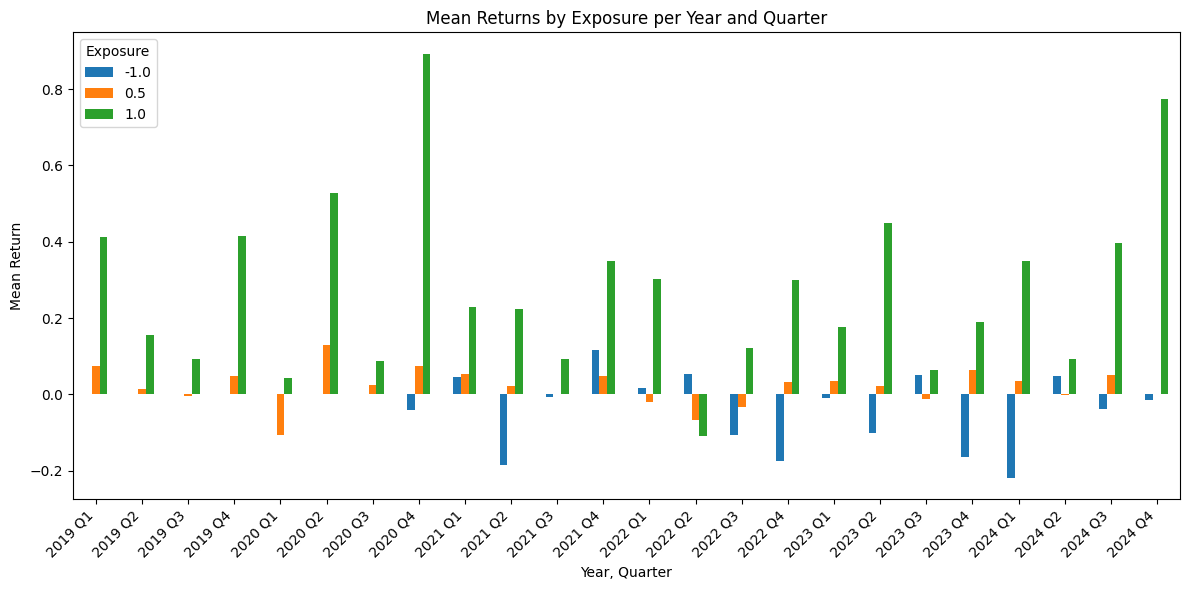

In [94]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `simulation` DataFrame is already loaded

# Group, calculate mean, and pivot

# Combine 'year' and 'quarter' into a single index for the x-axis
analysis['Year-Quarter'] = analysis.index.map(lambda x: f"{x[0]} Q{x[1]}")

# Reset index for plotting
analysis.reset_index(drop=True, inplace=True)

# Plot a bar chart
analysis.set_index("Year-Quarter").plot(
    kind="bar",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Customize the plot
plt.xlabel("Year, Quarter")
plt.ylabel("Mean Return")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title="Exposure")
plt.tight_layout()

# Show the plot
plt.show()
